In [1]:
%matplotlib inline

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import sklearn
import plotly.express as px


import nltk.collocations 
from nltk import FreqDist, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from collections import Counter
import string, re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('words')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import wordcloud
from wordcloud import WordCloud
from nltk import NaiveBayesClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import MinMaxScaler
import pickle

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


# Can we predict  music genre based on lyrics? Are there typical words for popular genres?

### Abstract


This study focused on classifying songs, scraped with lyrics genius library, based on Spotify features, to their musical genre by performing Naive Bayes,Random Forest and Ada Boost Classifiers on their lyrics. 

This project aimed to investigate how accurately a model can predict songs' genre based on their lyrics. Taking into account  previous researches on suprevised machine learning models*, we wanted to experiment whether our models can score higher than 0.50%. Unfortunately, the highest score with our best performing model - Ada Boost (with logistic Regression) was 0.46.

## Introduction

Music has always played an integral role in human lives ever since the emerging of civilizations and even before - when humans were leaving in tribes. It is a form of art, a way to express one's feelings, a way to convey information, storytelling, a social act of bonding people, an entertainment, a history of humans. Different historical eras were marked by the emerging and favoring of different music genres. Take for an example the Renaissance epoch - the rise of humanism and its impact on the secular music or post-world-war period and the wave of protest music such as rock and roll or blues. All these historical events had a huge impact on music - instrumental and text, creating new music genres.

Nowadays there are hundreds of music genres based on the different features of the songs, as most of them are stemming from a few main genres. Moreover, artists continue to explore different music styles throughout their careers, making the borders between them very thin or even making them disappear. Rock band Red Hot Chili Peppers employed rapping on some of their songs. Jimi Hendrix, The Rolling Stones, and Aerosmith were mixing rock with punk.

With all this complexity of the music, how can we tell what is the music genre of a song?

In this study, each song only has one genre label. In reality, assigning just one genre to a song can be more challenging when there is some degree of possible overlap between certain genres.

A song consists of two main components: instrumental accompaniment and vocals. The vocals mainly include pitch, gender of singer, and lyrics. Extensive work has been done on music genre classification based on acoustic features of a song, e.g., the instrumental accompaniment, the pitch, and the rhythm of the song.

This project explores the potential of classifying a song’s genre based on its lyrics. Our main idea is to extract the information from a song’s lyrics and identify features that help music genre classification. In particular, we consider the frequency of words and identify those words that appear more frequently in a specific music genre.
We have already concluded that music genres arose and evolved under the impact of historical events and that are culture-specific, thus different music genres have typical language and prominent wording. For instance, country songs usually include words such as “baby”, “boy”, “way”, and Hip hop may include words like “suckers,” “y’all,” “yo,” and “
ain’t”.


The analysis of lyrics relies on natural language processing (NLP) techniques. In NLP the aim is to assign meaning and labels to text. Traditional approaches in text classification have utilized n-gram models and algorithms such as
Support Vector Machines (SVMs), k-Nearest Neighbour (k-NN), and Naïve Bayes (NB).In recent years the use of deep learning methods such as recurrent neural networks (RNNs) or convolutional neural networks (CNNs) has produced superior results and represents an exciting breakthrough in NLP. In this project, we will limit our models to supervised machine learning methods. 


First, we will prepare the lyrics with NLP, by lemmatazing the word, removing stopwords, and tokenizing the words. 
Then we will use TF-IDF or Term Frequency-Inverse Document Frequency to determine how frequently a word in lyrics per genre appears and how important it is to it. And finally, we will apply the following algorithms: Naive Bayes, Random Forest and Ada Boost.

## Cleaning the text 

In [3]:
spotify = pd.read_csv('final_with_lyrics.csv')

In [4]:
spotify.genre_name.unique()

array(['rock', 'country', 'pop', 'hip-hop/rap', 'r&b', 'metal'],
      dtype=object)

In [5]:
spotify.groupby(['genre_name']).size()

genre_name
country        950
hip-hop/rap    950
metal          950
pop            950
r&b            950
rock           950
dtype: int64

Unfortunately, while scraping the lyrics with genius lyrics library some of the requests mixed up with data, different from lyrics, such as novels chapters, screenplay, etc. The usual size of songs is not exceeding 6000 symbols, thus we will have to further clear the lyrics

In [6]:
spotify_updated = (spotify.where(spotify.lyrics.str.len() < 6000)).dropna()

In [7]:
spotify_updated.groupby(['genre_name']).size()

genre_name
country        897
hip-hop/rap    876
metal          946
pop            884
r&b            921
rock           855
dtype: int64

Again, to make the dataset balanced we will cut from the dataframe even number of songs per genre, in this case it will be 855.

In [8]:
final_rock_df = spotify_updated[spotify_updated.genre_name == "rock"][-855:]
final_country_df = spotify_updated[spotify_updated.genre_name == "country"][-855:]
final_pop_df = spotify_updated[spotify_updated.genre_name == "pop"][-855:]
final_r_n_b_df = spotify_updated[spotify_updated.genre_name == "r&b"][-855:]
final_metal_df = spotify_updated[spotify_updated.genre_name == "metal"][-855:]
final_hip_hop_df = spotify_updated[spotify_updated.genre_name == "hip-hop/rap"][-855:]

In [9]:
spotify_lyrics = final_rock_df.append([final_country_df, final_pop_df, final_hip_hop_df, final_r_n_b_df,final_metal_df])

In [10]:
spotify_lyrics.groupby(['genre_name']).size()

genre_name
country        855
hip-hop/rap    855
metal          855
pop            855
r&b            855
rock           855
dtype: int64

## Preparing the text 
### Removing all non-letter characters, lower case words, removing stopwords, performing lemmatization

We chose to use lemmatization of words to stemming, because, unlike Stemming, Lemmatization reduces the inflected words properly ensuring that the root word belongs to the language.

In [11]:
### tokenization of the text, removing stop words and lemmatization

pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

lemmatizer = WordNetLemmatizer()
english = list(set(nltk.corpus.words.words()))

def clean_docs_lemma(df):

    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    for artist, song, lyric, genre in zip(df.artist_name, df.track_name, df.lyrics, df.genre_name):
        clean_lyric = nltk.regexp_tokenize(lyric, pattern)
        lyric_lower = [i.lower() for i in clean_lyric]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        stopwords_list += ['embedshare','urlcopyembedcopy', 'feat',"i'm","i'll","i've", "you've", "i'd"]
        lyrics_tokens_stopped = [w for w in lyric_lower if not w in stopwords_list]
        lyric_lemmas = [lemmatizer.lemmatize(word) for word in lyrics_tokens_stopped if word!='']
        
        c = " ".join(lyric_lemmas)
       
        row = df[(df.artist_name == artist) & (df.track_name == song)].index.item()
        df.at[row,'lyrics'] = c
    return df

In [12]:
lemmed_lyrics = clean_docs_lemma(spotify_lyrics)

In [13]:
#test
lemmed_lyrics.lyrics

0       got afternoon got room two one thing left disc...
1       know die cry know die know breathe bleed know ...
2       mayday mayday ship slowly sinking think crazy ...
3       darling waiting got alone wanna go darling wai...
4       say surely break leaving one wanna take forgiv...
                              ...                        
5695    wanna wanna wanna wanna never made much sense ...
5696    wishing anymore writing song sleep better dark...
5697    surrender surrender wall melt gaze sunshine cl...
5698    fed fed fed never want peace thrive panic fed ...
5699    know bend break promise time truth keep head c...
Name: lyrics, Length: 5130, dtype: object

### Data Exploration and vizualization

In [14]:
english_stop_words = stopwords.words('english')

We can check which one is the music genre with the longest lyrics from them all.

In [17]:
l = lemmed_lyrics.groupby('genre_name').aggregate({'lyrics':'\n'.join})
l['line_text'] = l['lyrics'].apply(lambda x:len(x))
fig = px.bar(x = l.index,y = l['line_text'],title = 'Total number of words per genre')
fig.update_layout(
xaxis_title='Genre',
yaxis_title='Total Number of words')
fig.show()

R&B is the music genre with the longest texts and rock is with the shortest.

**Using Term Frequency Counter to show the top words per genre**

In [18]:
def word_freq(df, genre):
    
    df = lemmed_lyrics.where(lemmed_lyrics.genre_name == genre).dropna()
    vectorizer = CountVectorizer(stop_words = english_stop_words, min_df=0.1,max_df=0.7)
    doc_matrix = vectorizer.fit_transform(df.lyrics)
    doc_matrix = pd.DataFrame(doc_matrix.toarray(), columns=vectorizer.get_feature_names())
    a = (doc_matrix.sum()).to_dict()
    tf_dict = dict(sorted(a.items(), key=lambda item: -item[1]))

    return tf_dict

In [19]:
def visualize_freq(d):
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
    plt.figure(figsize=(20,12))
    
    plt.imshow(wordcloud)

In [20]:
tf_dict_rock = word_freq(lemmed_lyrics, 'rock')

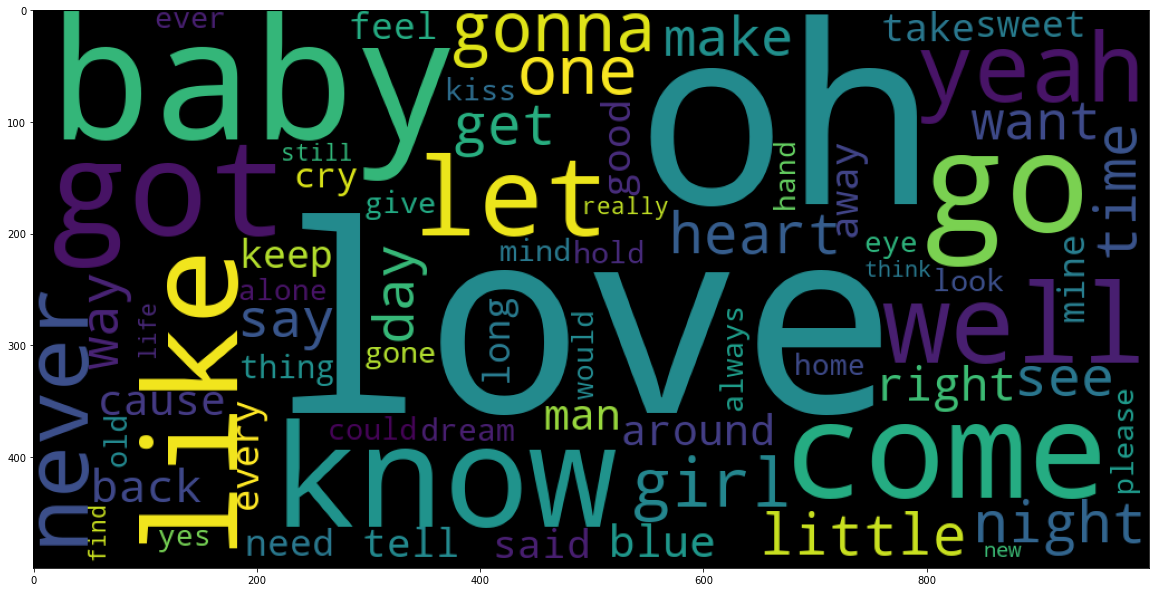

In [21]:
visualize_freq(tf_dict_rock)

In [22]:
tf_dict_rap = word_freq(lemmed_lyrics, 'hip-hop/rap')

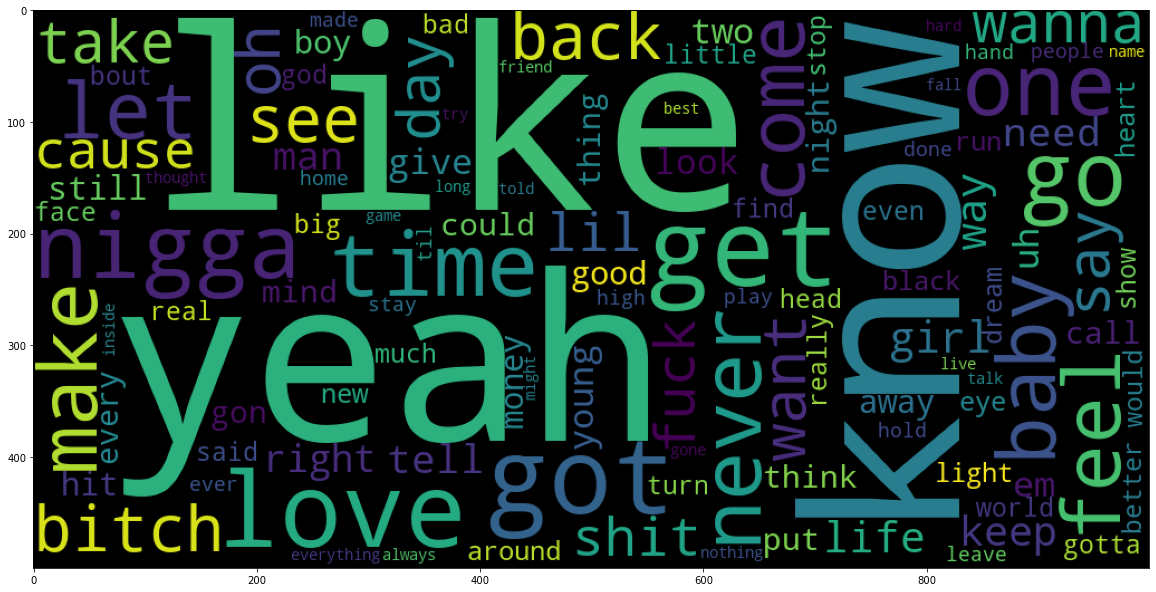

In [23]:
visualize_freq(tf_dict_rap )

In [24]:
tf_dict_country = word_freq(lemmed_lyrics, 'country')

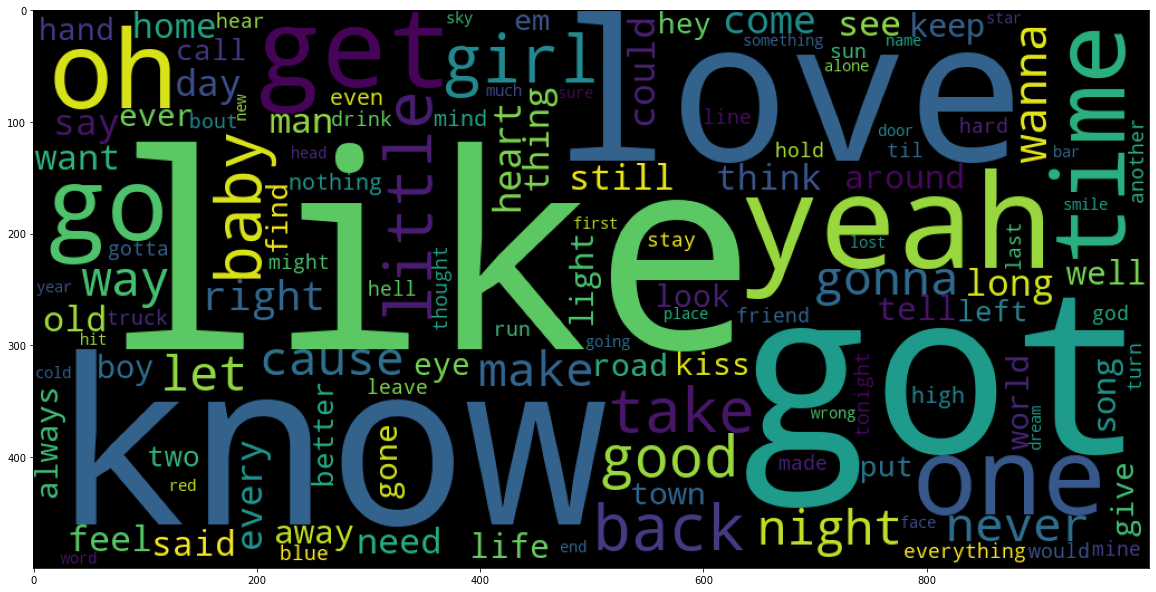

In [25]:
visualize_freq(tf_dict_country)

In [26]:
tf_dict_metal = word_freq(lemmed_lyrics, 'metal')

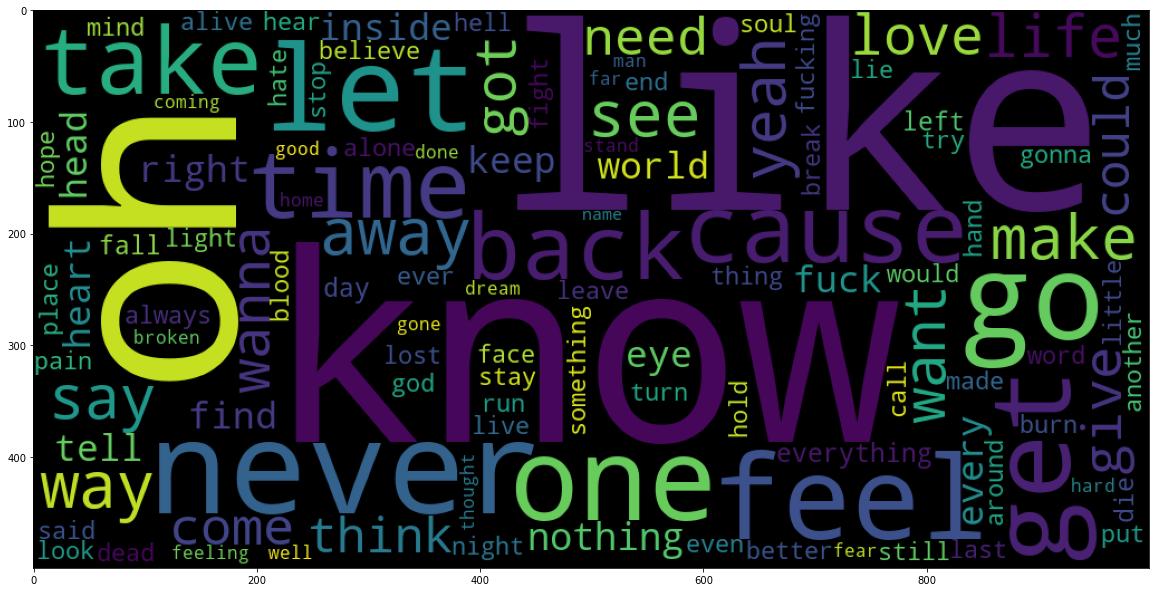

In [27]:
visualize_freq(tf_dict_metal)

In [28]:
tf_dict_r_n_b = word_freq(lemmed_lyrics, 'r&b')

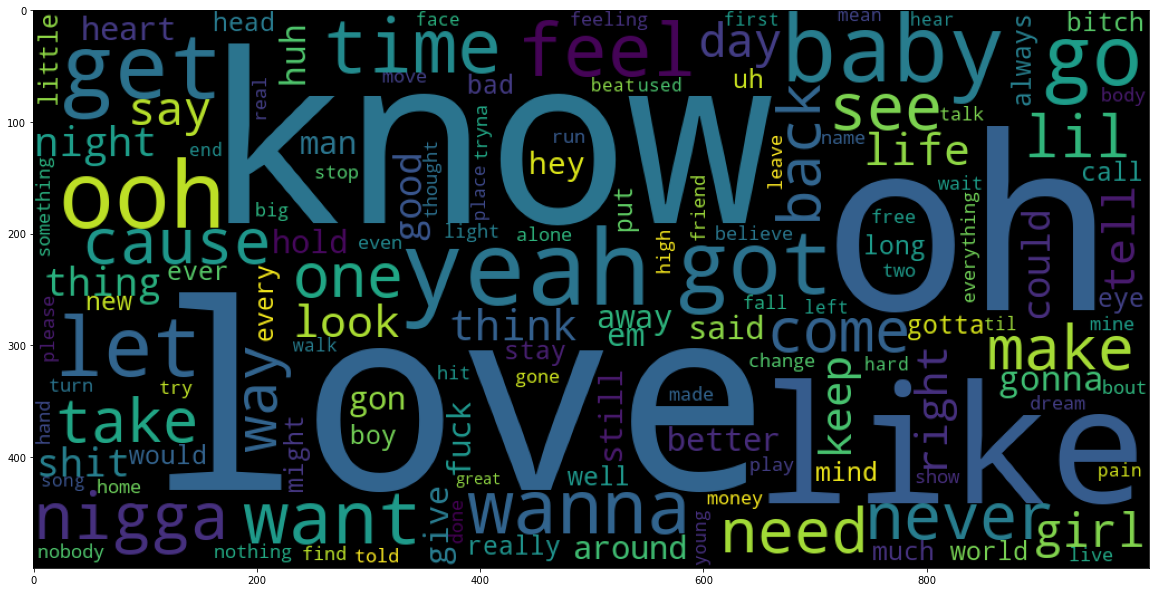

In [29]:
visualize_freq(tf_dict_r_n_b)

In [30]:
tf_dict_pop = word_freq(lemmed_lyrics, 'pop')

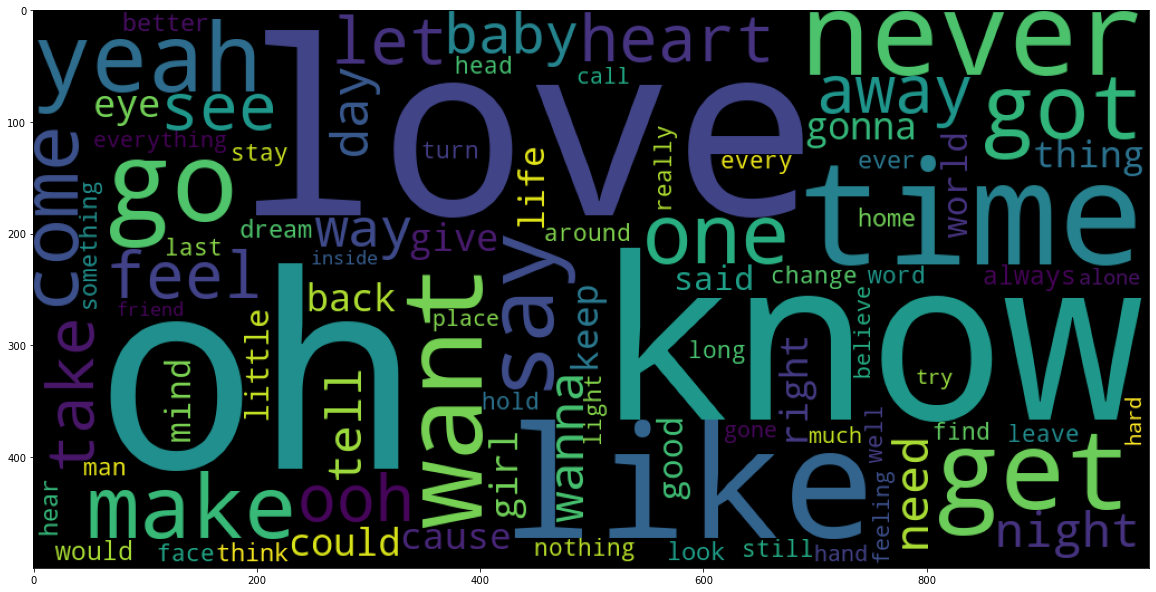

In [31]:
visualize_freq(tf_dict_pop)

In [131]:
Counter(tf_dict_rap).most_common(10)

[('like', 2108),
 ('yeah', 1779),
 ('know', 1530),
 ('get', 1477),
 ('got', 1427),
 ('love', 1369),
 ('nigga', 985),
 ('go', 982),
 ('time', 952),
 ('one', 885)]

In [132]:
Counter(tf_dict_country).most_common(10)

[('like', 1988),
 ('know', 1359),
 ('got', 1342),
 ('love', 1317),
 ('yeah', 1248),
 ('get', 1144),
 ('oh', 1106),
 ('one', 1095),
 ('go', 976),
 ('time', 944)]

In [133]:
Counter(tf_dict_pop).most_common(10)

[('oh', 1978),
 ('love', 1593),
 ('know', 1373),
 ('like', 1064),
 ('time', 1054),
 ('never', 1009),
 ('go', 924),
 ('want', 898),
 ('get', 895),
 ('yeah', 845)]

In [135]:
Counter(tf_dict_metal).most_common(10)

[('know', 1663),
 ('like', 1584),
 ('oh', 1470),
 ('never', 1338),
 ('go', 1125),
 ('let', 1076),
 ('feel', 1020),
 ('one', 1013),
 ('get', 909),
 ('cause', 883)]

As we can see, the most common words per genre are not varying much between different genres, thus it will be difficult to differentiate them. Vectorizing based on counts will not work, we need to add weights/importance to those words. That is why we will use TF-IDF vectorizer.

###  TF - IDF

TF-IDF rescales the frequency of words by how often they appear in all documents so that the scores for frequent words that are also frequent across all documents are penalized.TF-IDF is intended to reflect how relevant a term is in a given document. 

TF-IDF for a word in a document is calculated by multiplying two different metrics:

**Term frequency**

Term frequency, tf(t,d), is the frequency of term t:
$$ \text{tf(t,d)} =  \frac{f t,d}{\sum_ {t^\prime \in d}f t^\prime,d}  $$
  
where $ft,d$ is the raw count of a term in a document

**Inverse document frequency**

IDF is a measure of how important a term is.

$$ \text{idf(t,D)} =  \log\frac{N}{|{\{d\in D : t \in d}\}|} $$


with:

$N$: total number of documents in the corpus $N = |D|$

$|{\{d\in D : t \in d}\}|$ : number of documents where the term $t$ appears $(\text{i.e tf}(t,d) \neq 0)$ If the term is not in the corpus, this will lead to a division-by-zero. It is therefore common to adjust the denominator to $ 1+ |{\{d\in D : t \in d}\}$

**Term frequency–Inverse document frequency**

Then tf–idf is calculated as:

$$ \text{tfidf}(t,d,D)= \text{tf}(t,d)\cdot \text{idf}(t,D) $$

In [32]:
tfidf = TfidfVectorizer(input = "content", analyzer = "word",ngram_range = (1, 1), min_df = 0, stop_words = english_stop_words, sublinear_tf = True)
response = tfidf.fit_transform(lemmed_lyrics.lyrics)

In [33]:
vectorized_df = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())
vectorized_df.shape

(5130, 26036)

In [35]:
vectorized_df.head()

,aa,aaaaaaaaaaaaass,aaaaaaaah,aaaaah,aaaaahh,aaaaahhh,aaaaaooowww,aaaah,aaaahhhh,aaah,...,zsa,zucker,zug,zulema,zulu,zum,zwei,zy,zz,zzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modelling and testing the data

### Dimensionality Reduction with PCA

We will use PCA to reduce the dimensionality of the vectorized lyrics ( we will not work with  the whole vocabulary). We want to reduce the dataset in order to get 95% of the variance.

In [36]:
pca = PCA()
pca_ = pca.fit_transform(vectorized_df)

In [37]:
pca_

array([[ 3.43221375e-02, -1.25057060e-02, -1.02872251e-02, ...,
         4.77909238e-27,  5.38497573e-28,  2.79805378e-27],
       [ 2.77913168e-02, -6.79660652e-02, -9.87889242e-02, ...,
         4.77907799e-27,  5.38480711e-28,  2.79803493e-27],
       [ 1.27741023e-02, -6.56626607e-02, -8.39882524e-02, ...,
         4.77907571e-27,  5.38450354e-28,  2.79802971e-27],
       ...,
       [ 1.58335702e-02,  4.88144889e-02, -6.35722747e-02, ...,
         4.77916537e-27,  5.38488669e-28,  2.79804198e-27],
       [-3.69403618e-02,  4.00645326e-03, -2.39120276e-02, ...,
         4.77913427e-27,  5.38488720e-28,  2.79805199e-27],
       [-8.54559141e-03,  1.65155095e-02, -6.44693970e-02, ...,
         4.77917110e-27,  5.38521254e-28,  2.79798555e-27]])

In [39]:
explained_variance_ratio_sum = np.cumsum(pca.explained_variance_ratio_)

In [40]:
def plot_cum_expl_var(data):
    plt.figure(figsize=(6, 4))
    plt.plot(range(data.shape[1]), explained_variance_ratio_sum)
    plt.axvline(np.where(explained_variance_ratio_sum >= 0.95)[0][0] + 1, color="green", linestyle="--", label = '95% explained variance')
    plt.axvline(np.where(explained_variance_ratio_sum >= 0.90)[0][0] + 1, color="yellow", linestyle="--", label = '90% explained variance')
    plt.axvline(np.where(explained_variance_ratio_sum >= 0.80)[0][0] + 1, color="red", linestyle="--",label = '80% explained variance')
    
    
    
    plt.legend()
    plt.title("PCA explained variance vs number of components")
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance [%]')
    plt.show()

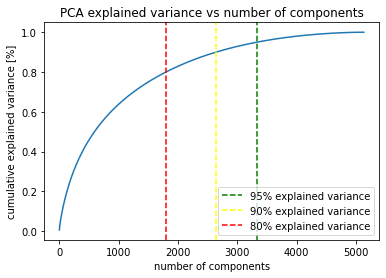

In [41]:
plot_cum_expl_var(pca_)

In [42]:
pca_95 = PCA(n_components = 0.95)
pca_reduced = pca_95.fit_transform(vectorized_df)

In [43]:
pca_reduced.shape

(5130, 3327)

In [44]:
x_lyrics = pca_reduced
y_genre = lemmed_lyrics.genre_name

In [45]:
x_train_l, x_test_l, y_train_g, y_test_g = train_test_split(x_lyrics, y_genre, test_size=0.2, random_state=42)

### Cross validation of  the data with K-Fold

To evaluate the performance of the classification algorithm used in this study we will apply k-fold cross validation. Generally, when the amount of data is large, k-fold cross-validation should be employed
to estimate the accuracy of the model, because the accuracy resulting from the training data of the model
is usually too optimistic. For example, when 80% of the data is used for training and 20%
of the data as test set, it is possible that the test set happens to contain data points that are particularly
easy (or hard) to predict. By adding Stratified we ensure that each fold of dataset has the same proportion of observations with a given label.

In [46]:
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

###  Baseline Classifier 
### Naive  Bayes Classifiers
### Multinomial NB and Gaussian NB

Naive Bayes classifiers are probabilistic classifiers that calculate the probability of each category using Bayes’ theorem, and output the category with the highest probability. It is known for its simplicity, accuracy, and speed, particularly when it comes to text classification. With Bayes' Theorem, we can more accuarately assess the probability that a certain song belongs to a particular genre, compared to the assessment of the probability of a genre made without knowledge of a song's lyrics.

Multinomial NB doesn't work with matrix factorization, because it does not accept negative values. MultinomialNB assumes that features have multinomial distribution which is a generalization of the binomial distribution. Neither binomial nor multinomial distributions can contain negative values. One way to use Multinomial NB is if we rescale the data to be in the range 0 to 1.

Gaussian NB on other hand can work with negative values and we can test it without rescaling the data. In this classifier, the assumption is that data from each label is drawn from a simple Gaussian distribution

In [51]:
scaler = MinMaxScaler()
scaled_data_nb = scaler.fit_transform(pca_reduced)

In [56]:
params_nb = {'alpha' :[1, 1e-1,1e-2]}
grid_search_nb = GridSearchCV(estimator = MultinomialNB(),param_grid = params_nb, cv = k_fold, scoring="f1_macro")
grid_search_nb.fit(scaler.fit_transform(x_train_l), y_train_g)
nb  = grid_search_nb.best_estimator_

print("Multinomial NB best score:", grid_search_nb.best_score_)

Multinomial NB best score: 0.37901177216301557


In [57]:
multinomial_nb_test = grid_search_nb.score(scaler.fit_transform(x_test_l), y_test_g)

In [58]:
multinomial_nb_test

0.16741576599682528

In [59]:
grid_search_nb.best_params_

{'alpha': 1}

In [60]:
params_G_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
grid_search_g_nb = GridSearchCV(estimator = GaussianNB(),param_grid = params_G_NB, cv = k_fold, scoring="f1_macro")
grid_search_g_nb.fit(x_train_l, y_train_g)
g_nb  = grid_search_g_nb.best_estimator_

print("Gaussian NB best score:", grid_search_g_nb.best_score_)

Gaussian NB best score: 0.25941219478179833


In [61]:
gaussian_g_nb_test = grid_search_g_nb.score(x_test_l, y_test_g)

In [62]:
gaussian_g_nb_test

0.2434520325460706

In [63]:
grid_search_g_nb.best_params_

{'var_smoothing': 1.0}

### Random Forest Classifier

In [47]:
params = {'n_estimators':[100, 200, 300], 'max_depth' : [20, 50, 100],'criterion' : ['gini', 'entropy'],}
grid_search = GridSearchCV(estimator = RandomForestClassifier(),param_grid = params, cv = k_fold, scoring="f1_macro")
grid_search.fit(x_train_l, y_train_g)
forest_classifier  = grid_search.best_estimator_

print("Random forest best score:", grid_search.best_score_)

Random forest best score: 0.435338461303887


In [109]:
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 300}

In [110]:
forest_classifier_testing_score = grid_search.score(x_test_l, y_test_g)

In [111]:
forest_classifier_testing_score

0.41814571643190396

### Gradient Boost Classifier

Unfortunatelly the model was interupred while training, because it took it more than 24 hours.

In [ ]:
'''
params_gboost = {"learning_rate": [0.2, 0.25],
    "min_samples_leaf": [3],
    "n_estimators":[100, 150]}
grid_search_gboost = GridSearchCV(estimator = GradientBoostingClassifier(),param_grid = params_gboost, cv = k_fold, scoring="f1_macro")
grid_search_gboost.fit(x_train_l, y_train_g)
g_boost  = grid_search_gboost.best_estimator_

print("Gradient Boost Classifier best score:", grid_search_gboost.best_score_)
'''


### Ada Boost Classifier

#### Ada Boost Classifier with Random Forest

Unfortunately, the model was interrupted because it couldn't finish training for more than 24 hours.

In [100]:
'''
k_fold_ada = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
params_ada = {"n_estimators": [100,150], "base_estimator": [RandomForestClassifier(criterion='gini', max_depth=20,n_estimators=300)]}
grid_search_ada = GridSearchCV(estimator = AdaBoostClassifier(),param_grid = params_ada, cv = k_fold_ada, scoring="f1_macro")
grid_search_ada.fit(x_train_l, y_train_g)
ada_forest_classifier  = grid_search_ada.best_estimator_

print("Ada Boost with Random forest; best score:", grid_search_ada.best_score_)
'''


'\nk_fold_ada = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)\nparams_ada = {"n_estimators": [100,150], "base_estimator": [RandomForestClassifier(criterion=\'gini\', max_depth=20,n_estimators=300)]}\ngrid_search_ada = GridSearchCV(estimator = AdaBoostClassifier(),param_grid = params_ada, cv = k_fold_ada, scoring="f1_macro")\ngrid_search_ada.fit(x_train_l, y_train_g)\nada_forest_classifier  = grid_search_ada.best_estimator_\n\nprint("Ada Boost with Random forest; best score:", grid_search_ada.best_score_)\n'

#### Ada Boost Classifier with Logistic Regression

In [104]:

k_fold_ada = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
params_ada = {"n_estimators": [100,150], "base_estimator": [LogisticRegression(C = 1e5, solver='liblinear')]}
grid_search_ada = GridSearchCV(estimator = AdaBoostClassifier(),param_grid = params_ada, cv = k_fold_ada, scoring="f1_macro")
grid_search_ada.fit(x_train_l, y_train_g)
ada_forest_classifier  = grid_search_ada.best_estimator_

print("Ada Boost with Logistic Regression; best score:", grid_search_ada.best_score_)

Ada Boost with Logistic Regression; best score: 0.4770044290197666


**Note: by mistake I wrote ada_forest classifier - it is logistic classifier**

In [105]:
grid_search_ada.best_params_

{'base_estimator': LogisticRegression(C=100000.0, solver='liblinear'),
 'n_estimators': 150}

In [125]:
ada_logistic_testing_score = grid_search_ada.score(x_test_l, y_test_g)

In [126]:
ada_logistic_testing_score

0.45789828546976913

## Final Result for the best model

In [152]:
predictions = grid_search_ada.predict(x_test_l)

In [153]:
predictions_probabilities = grid_search_ada.predict_proba(x_test_l)

In [154]:
print(classification_report(y_test_g, predictions))

              precision    recall  f1-score   support

     country       0.69      0.54      0.61       160
 hip-hop/rap       0.34      0.36      0.35       165
       metal       0.65      0.48      0.55       164
         pop       0.30      0.34      0.32       159
         r&b       0.34      0.48      0.40       185
        rock       0.59      0.48      0.53       193

    accuracy                           0.45      1026
   macro avg       0.48      0.45      0.46      1026
weighted avg       0.48      0.45      0.46      1026



The best model has overall accuracy score of 0.45 and macro avg of 0.46.

Pop and hip-hop had the lowest scores and country the highest.

In [116]:
conf_matrix = confusion_matrix(y_test_g, predictions, labels=np.unique(y_test_g))

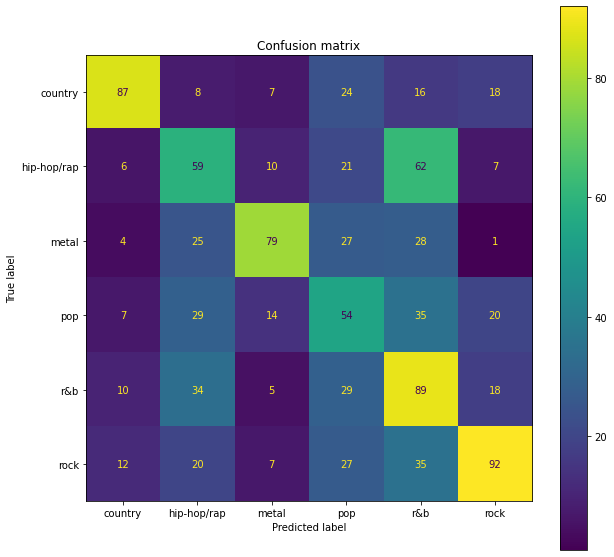

In [155]:
plt.figure(figsize=(10, 10))
plt.title("Confusion matrix")
display = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y_test_g))

display.plot(ax=plt.gca())
plt.show()

Pop is the most 'fluid' genre as it was mistaken the most, mainly with r&b and hip-hop and the least with metal. 

### Exploring the wrongly predicted genres

In [118]:
wrong = y_test_g != predictions

In [139]:
wrong_index = wrong.where(wrong.values ==True).dropna().index

In [180]:
most_mistaken_artists = lemmed_lyrics.loc[wrong_index].groupby(['artist_name']).size().sort_values(ascending=False)

In [181]:
most_mistaken_artists.nlargest(n = 15)

artist_name
elvis presley           16
dance gavin dance        9
zero 7                   8
kacey musgraves          5
a day to remember        5
frank ocean              5
tove lo                  5
stevie wonder            4
björk                    4
boards of canada         4
bring me the horizon     4
system of a down         4
surfaces                 4
chvrches                 4
spiritbox                4
dtype: int64

### Conclusion

Unfortunately even though we tried different classifiers, non of them managed to predict music genre with confidence.

As we have stated in the introduction - genres are fluid, thus difficult to distingish. 

What we can do in a future study:

* Combine audio features with lyrics to obrain better score
* Group in a better way the genres or use multi labeling
* Use Word2vec instead of TF-IDF 
* Try with NN models 
* Scrape more data 

## References

**Papers**:

* [Music Genre Classification by Lyrics ](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1174/reports/2728368.pdf)
* [Music genre classification using audio features and
lyrics sentiment features with multinomial logistic regression ](http://arno.uvt.nl/show.cgi?fid=147004)

**Notebooks**

* [how we used nltk and nlp to predict a songs genre from its lyrics](https://github.com/Botafogo1894/Project3/blob/master/Genre_Classifier_final.ipynb)

* [wordcloud visualization](https://github.com/ApurvGude/Song-genre-prediction/blob/master/notebooks/Text%20Mining%20with%20Songs.ipynb)

